In [1]:
%load_ext dotenv
%dotenv 
import os
import sys
sys.path.append(os.getenv('SRC_DIR'))
from logger import get_logger
_logs = get_logger(__name__)

In [2]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import os
from glob import glob

/var/folders/2r/1l6yc2bx3m56rxmdpbz1z5w80000gn/T/ipykernel_55028/1500862777.py:1: DeprecationWarning: The current Dask DataFrame implementation is deprecated. 
In a future release, Dask DataFrame will use new implementation that
contains several improvements including a logical query planning.
The user-facing DataFrame API will remain unchanged.

The new implementation is already available and can be enabled by
installing the dask-expr library:

    $ pip install dask-expr

and turning the query planning option on:

    >>> import dask
    >>> dask.config.set({'dataframe.query-planning': True})
    >>> import dask.dataframe as dd

API documentation for the new implementation is available at
https://docs.dask.org/en/stable/dask-expr-api.html

Any feedback can be reported on the Dask issue tracker
https://github.com/dask/dask/issues 

  import dask.dataframe as dd


In [3]:
ft_dir = os.getenv("FEATURES_DATA")
ft_dir

ft_glob = glob(ft_dir+'/*.parquet')
ft_glob

['../../05_src/data/features/stock_features.parquet/part.384.parquet',
 '../../05_src/data/features/stock_features.parquet/part.394.parquet',
 '../../05_src/data/features/stock_features.parquet/part.245.parquet',
 '../../05_src/data/features/stock_features.parquet/part.255.parquet',
 '../../05_src/data/features/stock_features.parquet/part.410.parquet',
 '../../05_src/data/features/stock_features.parquet/part.400.parquet',
 '../../05_src/data/features/stock_features.parquet/part.123.parquet',
 '../../05_src/data/features/stock_features.parquet/part.133.parquet',
 '../../05_src/data/features/stock_features.parquet/part.141.parquet',
 '../../05_src/data/features/stock_features.parquet/part.151.parquet',
 '../../05_src/data/features/stock_features.parquet/part.472.parquet',
 '../../05_src/data/features/stock_features.parquet/part.462.parquet',
 '../../05_src/data/features/stock_features.parquet/part.227.parquet',
 '../../05_src/data/features/stock_features.parquet/part.237.parquet',
 '../.

In [4]:
ft_dir = os.getenv("FEATURES_DATA")
ft_glob = glob(ft_dir+'/*.parquet')
df = dd.read_parquet(ft_glob).compute().reset_index()

# Sampling in Python

+ There are different packages that allow sampling.
+ A practical approach is to use pandas/Dask sampling methods.

## Random Sampling

+ Sample n rows from a dataframe with [`df.sample()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html).

```
DataFrame.sample(
    n=None, frac=None, replace=False, weights=None, 
    random_state=None, axis=None, ignore_index=False
    )
```

In [5]:
df.sample(n = 5)

,ticker,Date,Open,High,Low,Close,Adj Close,Volume,sector,subsector,year,Close_lag_1,returns,positive_return,target
227883,AEE,2016-04-27,46.959999,47.480000,46.570000,47.259998,36.861137,1860300,Utilities,Multi-Utilities,2016,46.810001,0.009613,1,1.0
1889680,WM,2000-08-25,19.187500,19.250000,18.750000,18.875000,10.712868,1248100,Industrials,Environmental & Facilities Services,2000,19.125000,-0.013072,0,1.0
1711254,GILD,2014-04-17,69.370003,70.639999,69.089996,70.000000,50.412403,17546400,Health Care,Biotechnology,2014,69.279999,0.010393,1,1.0
1378744,PFG,2021-12-06,70.180000,70.989998,69.610001,69.980003,63.533947,2326200,Financials,Life & Health Insurance,2021,69.180000,0.011564,1,1.0
1082072,EVRG,2019-12-20,63.900002,64.330002,63.660000,64.120003,53.237930,4664200,Utilities,Electric Utilities,2019,63.700001,0.006593,1,0.0


In [6]:
# select_tickers = df['ticker'].unique().tolist()[0:9]
select_tickers = ['OXY', 'TXN', 'PCG', 'CBRE', 'ROK', 'AMT', 'D', 'YUM', 'PWR']
select_tickers

['OXY', 'TXN', 'PCG', 'CBRE', 'ROK', 'AMT', 'D', 'YUM', 'PWR']

In [7]:
idx = df['ticker'].isin(select_tickers)
small_df = df[idx]
simple_sample_dt = small_df.sample(frac = 0.1)
simple_sample_dt.shape, small_df.shape

((5507, 15), (55073, 15))

Look at the distribution of tickers.

<Axes: xlabel='ticker'>

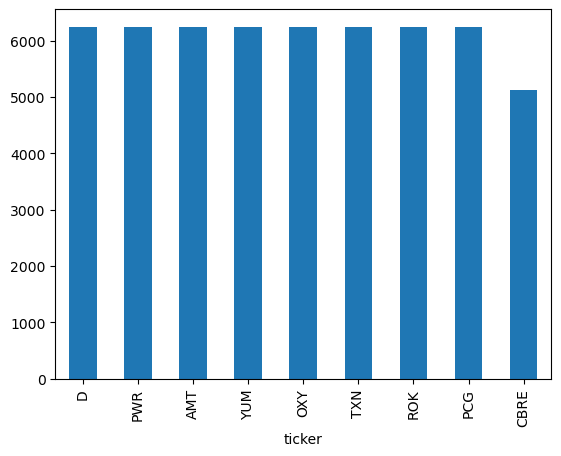

In [8]:
small_df['ticker'].value_counts().plot(kind='bar')

<Axes: xlabel='ticker'>

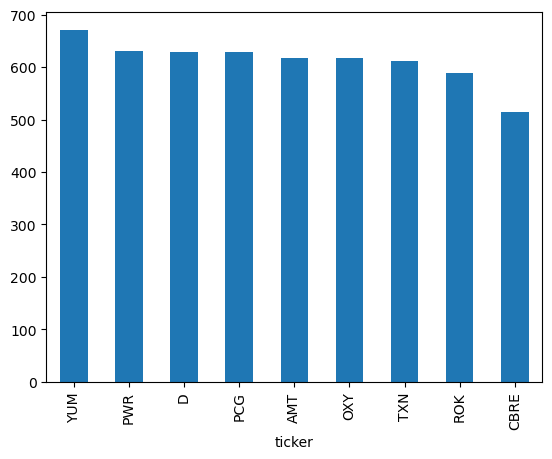

In [9]:
simple_sample_dt['ticker'].value_counts().plot(kind='bar')

## Stratified Sampling

+ Use `groupby()` and `.sample()` for stratified sampling.

<Axes: xlabel='ticker'>

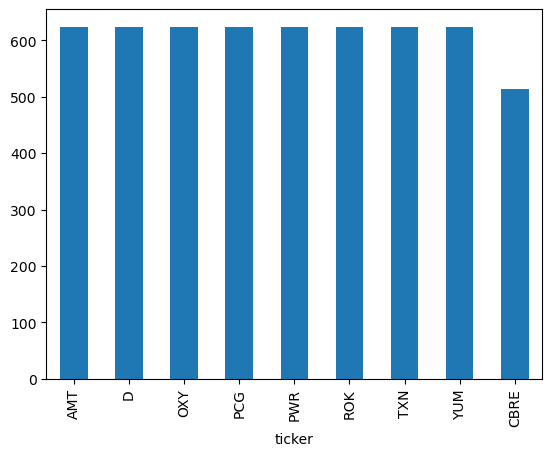

In [10]:
strat_sample_dt = small_df.groupby(['ticker']).sample(frac = 0.1)
strat_sample_dt['ticker'].value_counts().plot(kind='bar')

# Sampling in Dask

+ Stratified sampling in `dask` can be achieved with `groupby().apply()` and a lambda function.

/var/folders/2r/1l6yc2bx3m56rxmdpbz1z5w80000gn/T/ipykernel_55028/2932236319.py:2: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  strat_sample_dd_dt = (dd_dt


<Axes: xlabel='ticker'>

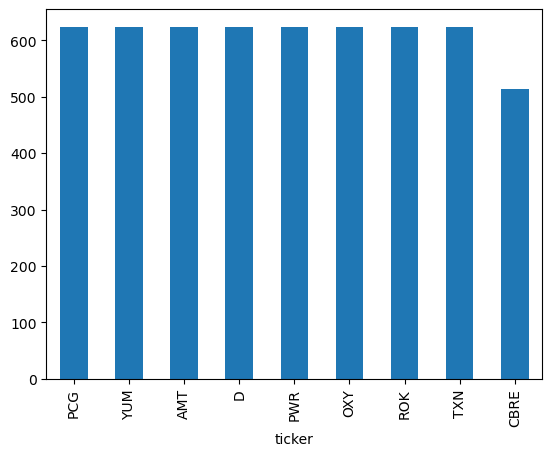

In [11]:
dd_dt = dd.read_parquet(ft_glob)
strat_sample_dd_dt = (dd_dt
                      .groupby('ticker', group_keys=False)
                      .apply(lambda x: x.sample(frac = 0.1))
                      .compute()
                      .reset_index())
strat_sample_dd_dt[strat_sample_dd_dt['ticker'].isin(select_tickers)]['ticker'].value_counts().plot(kind='bar')